In [2]:
# Check if the python notebook is working
print("Im Working!")

Im Working!


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm
import seaborn as sns

In [4]:
# Read the dataset
df = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
# Since there are a lot of missing values in ticket and cabin we will drop them
# Additionally features like Name and PassengerId carry no apparent importance as features, so they will also be removed, 
# before applying encoding on our categorical values 
df = df.drop(['Name', 'PassengerId', 'Ticket','Cabin'], axis=1) 
df = df.dropna()

## Wrapper Methods

We will use the random forest algorithm. This method is part of the scikit package and requires all features to be continueous values. Thus pre-processing of the data is imperative. All categorical features will be encoded into one-hot arrays. It is known that such an approach can hurt performance. 

In [6]:
# Encoding our categorical data into one-hot arrays
# Encode Pclass, Sex and Embarked features
sex_enc = pd.get_dummies(df['Sex'])
embarked_enc = pd.get_dummies(df['Embarked'])
pclass_enc =  pd.get_dummies(df['Pclass'])

# Survived feature will be our independent variable
survived = df['Survived']

# Remove existing columns 
# Survived feature removed so as not to correlate 100% with only one feature during feature subset selection
df = df.drop(['Survived', 'Sex', 'Embarked', 'Pclass'], axis=1)

# Replace them with encoded ones
df = df.join(sex_enc)
df = df.join(embarked_enc)
df = df.join(pclass_enc)
df.columns = ['Age', 'SibSp', 'Parch', 'Fare', 
              'female', 'male', 
              'Embarked_C', 'Embarked_Q', 'Embarked_S', 
              'Pclass_1', 'Pclass_2', 'Pclass_3']
print(df[50:60])

      Age  SibSp  Parch     Fare  female  male  Embarked_C  Embarked_Q  \
68  17.00      4      2   7.9250       1     0           0           0   
69  26.00      2      0   8.6625       0     1           0           0   
70  32.00      0      0  10.5000       0     1           0           0   
71  16.00      5      2  46.9000       1     0           0           0   
72  21.00      0      0  73.5000       0     1           0           0   
73  26.00      1      0  14.4542       0     1           1           0   
74  32.00      0      0  56.4958       0     1           0           0   
75  25.00      0      0   7.6500       0     1           0           0   
78   0.83      0      2  29.0000       0     1           0           0   
79  30.00      0      0  12.4750       1     0           0           0   

    Embarked_S  Pclass_1  Pclass_2  Pclass_3  
68           1         0         0         1  
69           1         0         0         1  
70           1         0         1         0

In [7]:
# Split our training data for training + validation
from sklearn.model_selection import train_test_split

# Which columns to grab from the dataset
columns = ['Age', 'SibSp', 'Parch', 'Fare', 
            'female', 'male', 
            'Embarked_C', 'Embarked_Q', 'Embarked_S', 
            'Pclass_1', 'Pclass_2', 'Pclass_3']

# Grab the columns for the transformation
all_X = df[columns]
all_y = survived

# Define our train and test sets
train_X, test_X, train_y, test_y = train_test_split(
    all_X, all_y, test_size=0.20,random_state=0)
print('Training dataset shape:', train_X.shape, train_y.shape)
print('Testing dataset shape:', test_X.shape, test_y.shape)

('Training dataset shape:', (569, 12), (569L,))
('Testing dataset shape:', (143, 12), (143L,))


In [8]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=3, #12 for full accuracy plot
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(train_X, train_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   10.3s finished

[2018-09-28 10:33:24] Features: 1/12 -- score: 0.776821854559446[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    9.2s finished

[2018-09-28 10:33:33] Features: 2/12 -- score: 0.7978761061946903[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.6s finished

[2018-09-28 10:33:42] Features: 3/12 -- score: 0.808341669873028[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1

In [9]:
feat_cols_ff = list(sfs1.k_feature_idx_)
print(feat_cols_ff)

feat_cols_bf = list(sfs1.k_feature_idx_)
print(feat_cols_bf)
sfs1.subsets_

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


{1: {'avg_score': 0.776821854559446,
  'cv_scores': array([0.74782609, 0.8       , 0.75221239, 0.78761062, 0.79646018]),
  'feature_idx': (4,),
  'feature_names': ('female',)},
 2: {'avg_score': 0.7978761061946903,
  'cv_scores': array([0.8       , 0.8       , 0.7699115 , 0.79646018, 0.82300885]),
  'feature_idx': (4, 11),
  'feature_names': ('female', 'Pclass_3')},
 3: {'avg_score': 0.808341669873028,
  'cv_scores': array([0.82608696, 0.8173913 , 0.77876106, 0.79646018, 0.82300885]),
  'feature_idx': (4, 8, 11),
  'feature_names': ('female', 'Embarked_S', 'Pclass_3')},
 4: {'avg_score': 0.808341669873028,
  'cv_scores': array([0.82608696, 0.8173913 , 0.77876106, 0.79646018, 0.82300885]),
  'feature_idx': (4, 5, 8, 11),
  'feature_names': ('female', 'male', 'Embarked_S', 'Pclass_3')},
 5: {'avg_score': 0.803093497499038,
  'cv_scores': array([0.80869565, 0.8173913 , 0.77876106, 0.78761062, 0.82300885]),
  'feature_idx': (4, 5, 7, 8, 11),
  'feature_names': ('female', 'male', 'Embarked_

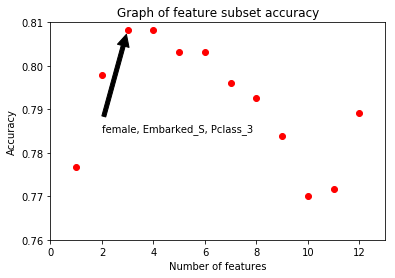

In [14]:
# plotting graph of feature sets' accuracy
#import matplotlib.pyplot as plt
#acc_scores = []
#num_feat = np.arange(1,13)
#for subset in sfs1.subsets_.values():
#    acc_scores.append(subset['avg_score'])
#scores = np.asarray(acc_scores)
#plt.plot(num_feat, scores, 'ro')
#plt.axis([0,13,0.76,0.81])
#plt.title('Graph of feature subset accuracy')
#plt.xlabel('Number of features')
#plt.ylabel('Accuracy')
#plt.annotate('female, Embarked_S, Pclass_3', xy=(3, 0.808341669873028), xytext=(2, 0.785),
#            arrowprops=dict(facecolor='black', shrink=0.05),
#            )
#plt.savefig('foo.png', bbox_inches='tight',dpi=1000)
#plt.show()

First testing the learning algorithm on all features:

In [11]:
from sklearn.metrics import accuracy_score as acc
# Build full model on ALL features, for comparison
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(train_X, train_y)

y_train_pred = clf.predict(train_X)
print('Training accuracy on all features: %.3f' % acc(train_y, y_train_pred))

y_test_pred = clf.predict(test_X)
print('Testing accuracy on all features: %.3f' % acc(test_y, y_test_pred))

Training accuracy on all features: 0.837
Testing accuracy on all features: 0.783


Then testing the learning algorithm on selected features only:

In [12]:
# Build full model with selected features
clf = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4)
clf.fit(train_X.iloc[:,feat_cols_ff], train_y)

y_train_pred = clf.predict(train_X.iloc[:,feat_cols_ff])
print('Training accuracy on selected features: %.3f' % acc(train_y, y_train_pred))

y_test_pred = clf.predict(test_X.iloc[:,feat_cols_ff])
print('Testing accuracy on selected features: %.3f' % acc(test_y, y_test_pred))

Training accuracy on selected features: 0.837
Testing accuracy on selected features: 0.783
